# Linear Regression

In this notebook, we show how to create, train and evaluate a linear regression model using Concrete-ML library, our open-source privacy-preserving machine learning framework based on fully homomorphic encryption (FHE). 

First, we generate a random clear dataset. Then, we compare 2 linear regression models :

- `linreg_sklearn` : from Sklearn, which is trained, tested and evaluated on clear data.   
- `linreg_concrete` : from Concrete-ML, which is trained on clear data. Then, quantized and compiled it in FHE. Finally, we test it on _encrypted data_.

This notebook aims to show how easy it is to use Concrete-ML and how FHE allows to secure the data during the inference phase.

Let's get started.

### Import libraries

We import the required packeges.

In [16]:
import time

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

And some helpers for visualization.

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Generate a dataset

In [18]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# We split the dataset into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# We sort the test set for a better visualization
idx_sorted = np.argsort(np.squeeze(X_test))
X_test = X_test[idx_sorted, :]
y_test = y_test[idx_sorted]

We display the dataset to visualize the data distribution.

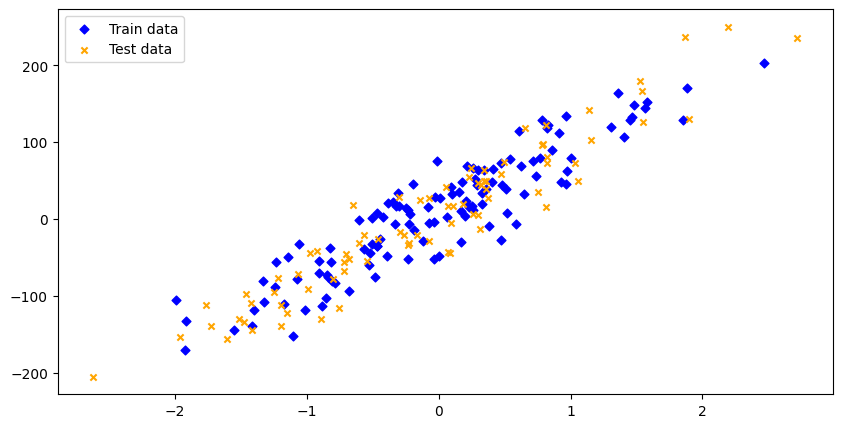

In [81]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, c="blue", marker="D", s=20, label="Train data")
ax.scatter(X_test, y_test, c="orange", marker="x", s=20, label="Test data")
ax.legend()
display(fig)

### 1. LinearRegression model from Sklearn 

We train the scikit-learn LinearRegression model on clear data and then we test it.

In [20]:
linreg = SklearnLinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

We can visualize our predictions to see how the scikit-learn model performs.

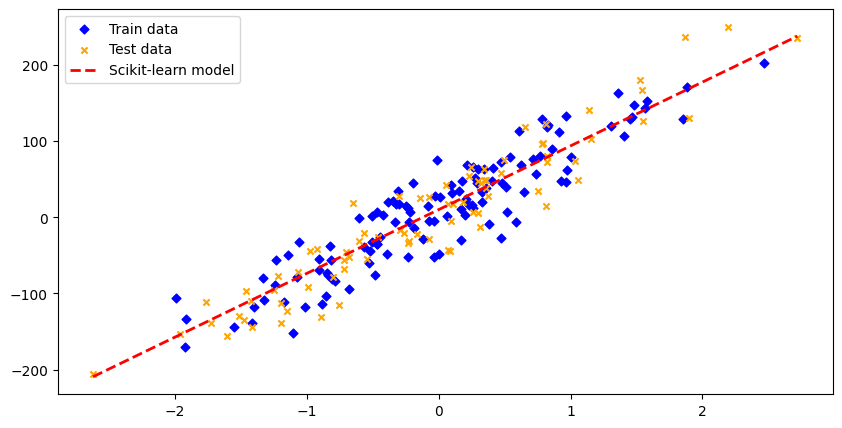

In [103]:
plt.ioff()
plt.clf()

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, c="blue", marker="D", s=20, label="Train data")
ax.scatter(X_test, y_test, c="orange", marker="x", s=20, label="Test data")
ax.plot(X_test, y_pred, c="red", linewidth=2, linestyle="dashed", label="Scikit-learn model")
ax.legend()
display(fig)

### Prerequisites

Some prerequisites should be reviewed before deep diving !

Quantization is a technique that converts continuous data (floating point, e.g., in 32-bits) to discrete numbers
within a fixed range (e.g. integer in 8-bits). However, there is a trade-off with quantization: some information will be lost. But, in some cases, the decrease in the performance, that quantization induces, is small and acceptable.

Regarding FHE, the input data type must be represented exclusively as integers. This is why we use quantization. Thus, with linear models, the model trained on floats is quantized into an equivalent integer using _Post-Training Quantization_. This operation can lead to a loss of accuracy compared to the standard floating point models working on clear data. 

To learn more about quantization, please refer to this [page](https://docs.preprod.zama.ai/concrete-ml/main/advanced-topics/quantization.html).

Moreover, Concrete-ML has a precision limitation: it doesn't support encrypted values larger than 8-bits integers. In other words, any floating points or high precision integers must be converted to an 8-bits equivalent for a model to work in FHE. In the upcoming releases, we expect more improvements regarding this issue.

### 2. Linear Regression model with Concrete-ML

The typical development flow of a Concrete-ML model is the following:

- The model is trained on clear (plaintext) data (only FHE inference is supported)

- The resulting trained model is quantized. To do so, you need to set `n_bits` parameter, which can be done in two different ways:
    1. with a dictionary composed of : 
        + `op_inputs` and `op_weights` : for all the hidden operators (mandatory)
        + `model_inputs` and `model_outputs` : for the overall network (optional, default to 5 bits)
        
        These parameters are given as integers representing the number of bits over which the associated data should be quantized.

    2. with an integer, representing the number of bits over which each input, output and weight should be quantized

- The quantized model is compiled to an FHE equivalent, and the compilation process can be broken up into 3 steps:

    + creation of an executable operation graph

    + checking that the op-graph is FHE compatible, i.e. checking the maximum bitwidth needed to execute the model

    + determining cryptographic parameters that will help to generate the secret keys and evaluation keys

- Inference can then be done on encrypted data

### 2.1 Quantized Linear Regression without FHE

In this example, we show you how to quantize a model with Concrete-ML, and how to train and test it on plaintext data.

In [22]:
# We quantize the inputs using 6-bits.
# And since our dataset has only one feature, we quantize the weights using only 1-bits
linreg_concrete = ConcreteLinearRegression(
    n_bits={"model_inputs": 6, "op_inputs": 6, "op_weights": 1, "model_outputs": 6}
)
# We train the concrete linear regression model on clear data
linreg_concrete.fit(X_train, y_train)

# Now, we can test our Concrete-ML model on the clear test data
y_pred_q = linreg_concrete.predict(X_test)

Now, let's visualize our predictions.

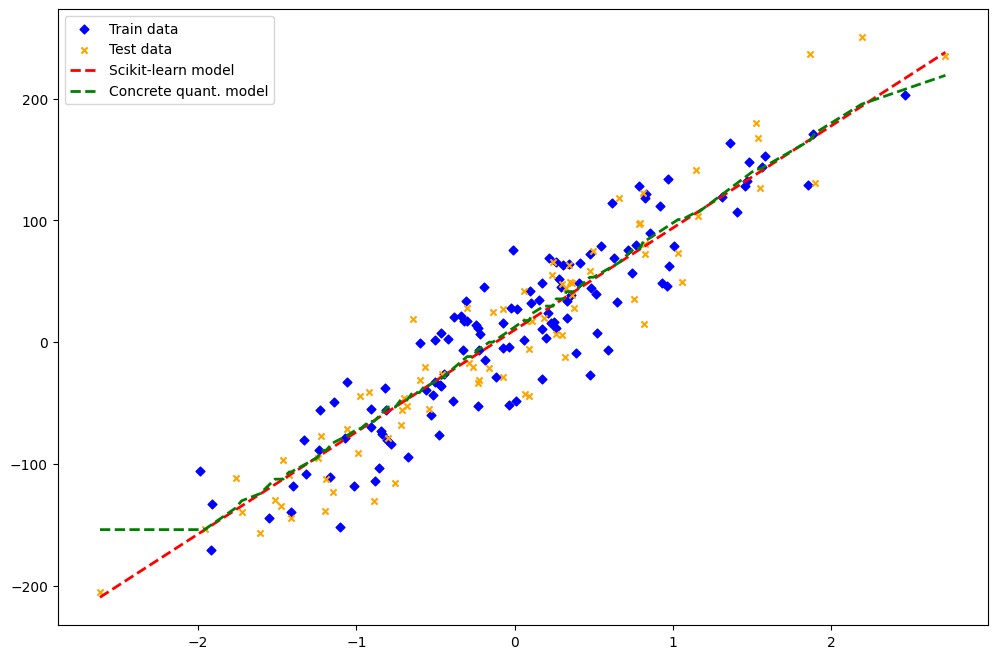

In [101]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, c="blue", marker="D", s=20, label="Train data")
ax.scatter(X_test, y_test, c="orange", marker="x", s=20, label="Test data")
ax.plot(X_test, y_pred, c="red", linewidth=2, linestyle="dashed", label="Scikit-learn model")
ax.plot(X_test, y_pred_q, c="green", linewidth=2, linestyle="dashed", label="Concrete quant. model")
ax.legend()
display(fig)

As you can see, there is a decrease in the performance with the quantized model. It generalizes poorly outside the training domain.

### 2.2 Quantized Linear Regression with FHE


To perform homomorphic inference, we take the above trained quantized model and we compile it to get an FHE model.
 
The compiler requires an exhaustive set of data to mainly evaluate the maximum integer bit-width within the graph, needed during the FHE computations, before running any predictions. 

You are free to provide the entire train dataset, or a smaller but representative subset, to the compiler.

In [24]:
circuit = linreg_concrete.compile(X_train)

#### Generate the key

The compiler returns a circuit, which can then be used for key generation and predictions:
- Secret Key: for the encryption and decryption
- Evaluation Key: to evaluate the circuit on encrypted data

In [25]:
print(f"Generating a key for a {circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 6-bit circuit


In [26]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 10.31 seconds


Now let's predict using the FHE model on encrypted data.

In [27]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = linreg_concrete.predict(X_test, execute_in_fhe=True)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} seconds per sample")

Execution time: 0.50 seconds per sample


### Evaluate all the models

In the following, we use $R^2$-score metric.

In [76]:
# Measure the error for all our models
sklearn_r2_error = r2_score(y_test, y_pred)
non_fhe_r2_error = r2_score(y_test, y_pred_q)
fhe_r2_error = r2_score(y_test, y_pred_fhe)

# Measure the error of the FHE quantized model w.r.t the clear quantized model
difference = abs(fhe_r2_error - non_fhe_r2_error) * 100 / non_fhe_r2_error

print(f"Scikit-learn R^2: {sklearn_r2_error:.4f}")
print(f"Non Homomorphic R^2: {non_fhe_r2_error:.4f}")
print(f"Homomorphic R^2: {fhe_r2_error:.4f}")
print(f"Relative Difference Percentage: {difference:.4f}%")

Scikit-learn R^2: 0.9013
Non Homomorphic R^2: 0.8958
Homomorphic R^2: 0.8958
Relative Difference Percentage: 0.0000%


### Plot the results of the Sklearn model and the FHE one

In [29]:
# For a better visualization

# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure.

x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_space_q = linreg_concrete.predict(x_space)

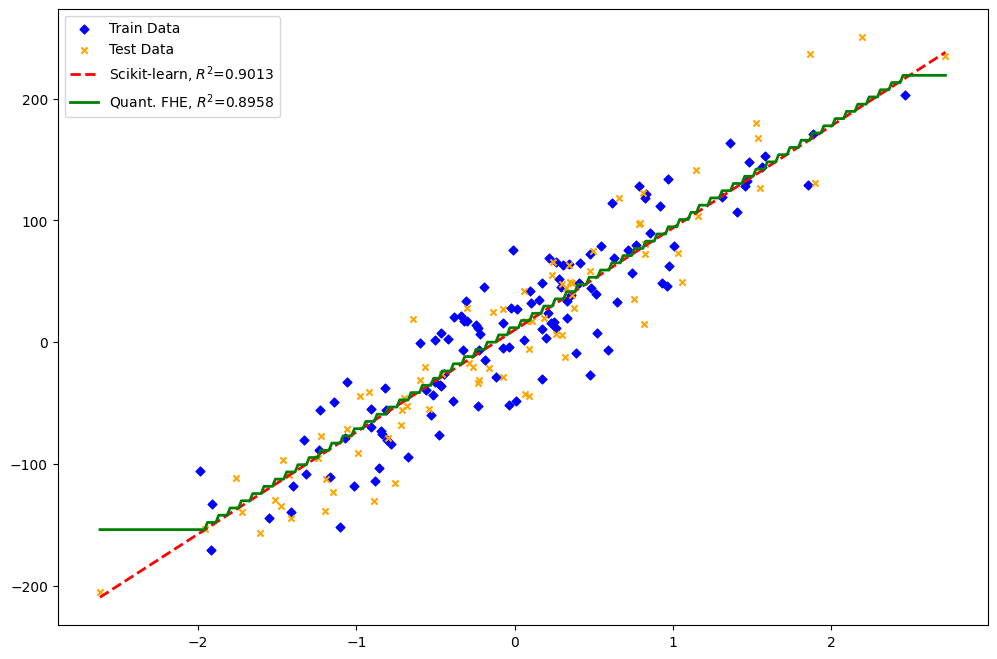

In [109]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
s1 = ax.scatter(X_train, y_train, c="blue", marker="D", s=20)
s2 = ax.scatter(X_test, y_test, c="orange", marker="x", s=20)
p1 = ax.plot(X_test, y_pred, c="red", linewidth=2, linestyle="dashed")
p2 = ax.plot(x_space, y_pred_space_q, c="green", linewidth=2)
ax.legend(
    [s1, s2, p1[0], p2[0]],
    [
        "Train Data",
        "Test Data",
        f"Scikit-learn, {'$R^2$'}={sklearn_r2_error:.4f}",
        f"Quant. FHE, {'$R^2$'}={fhe_r2_error:.4f}",
    ],
)
display(fig)

## Conclusion

In this tutorial, we have shown how easy it is to train and execute a linear regression model in FHE using Concrete-ML. 

We have also discussed the development flow of an FHE model (training, quantization, compilation and inference).

The slight decrease in prediction quality is due to the quantization of the model weights and input data. But, we have seen that there is only a very small difference between the floating point model and the FHE one.
